In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
np.warnings.filterwarnings('ignore')


Some resources: [Course](https://github.com/davidrosenberg/mlcourse) by David Rosenberg.

### Example 3.2.1, Full Model

- Read data_ from "prostate.txt", mask rows according to column "train".

In [186]:
data_ = pd.read_csv('prostate.txt', delimiter = '\t', index_col = 0)
train = data_.pop('train')
y= data_.pop('lpsa')
data_.head().round(decimals=3)

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
1,-0.580,2.769,50,-1.386,0,-1.386,6,0
2,-0.994,3.320,58,-1.386,0,-1.386,6,0
3,-0.511,2.691,74,-1.386,0,-1.386,7,20
4,-1.204,3.283,58,-1.386,0,-1.386,6,0
5,0.751,3.432,62,-1.386,0,-1.386,6,0


- Correlation of the training data.

In [187]:
data_[train=='T'].corr().round(decimals=3)

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
lcavol,1.000,0.300,0.286,0.063,0.593,0.692,0.426,0.483
lweight,0.300,1.000,0.317,0.437,0.181,0.157,0.024,0.074
age,0.286,0.317,1.000,0.287,0.129,0.173,0.366,0.276
lbph,0.063,0.437,0.287,1.000,-0.139,-0.089,0.033,-0.030
svi,0.593,0.181,0.129,-0.139,1.000,0.671,0.307,0.481
lcp,0.692,0.157,0.173,-0.089,0.671,1.000,0.476,0.663
gleason,0.426,0.024,0.366,0.033,0.307,0.476,1.000,0.757
pgg45,0.483,0.074,0.276,-0.030,0.481,0.663,0.757,1.000


Pairplot

In [188]:
# sns.pairplot(data_, plot_kws=dict(marker="s", size=1), diag_kws=dict(fill=True))

Standardize each column of "data_" by st.zscore. Given an array of $(a_i)_{i=0}^{n-1}$, the z-score of $a_i$ is given by
$$
z_i = \frac{a_i - \bar a}{\mathrm{ssd}}
$$
The StandardScaler and st.zscore (by default) set ddof to 0, which according to sk documents does not affect model performance.

In [191]:
scaler = StandardScaler()
columns, index = data_.columns, data_.index # after scaling the features and indices are lost
data_ = pd.DataFrame(scaler.fit_transform(data_.values), columns = columns, index = index);
# the three lines above are equivalent to ddof = 0 case below. 
# data_=data_.apply( lambda x: st.zscore(x, ddof=1), axis = 0)

In [192]:
np.set_printoptions(precision=3, suppress=True)
print(np.corrcoef(data_, rowvar = False))
print(np.cov(data_, rowvar = False))
# rowvar = False since the random variable samples are stored in columns

[[ 1.     0.281  0.225  0.027  0.539  0.675  0.432  0.434]
 [ 0.281  1.     0.348  0.442  0.155  0.165  0.057  0.107]
 [ 0.225  0.348  1.     0.35   0.118  0.128  0.269  0.276]
 [ 0.027  0.442  0.35   1.    -0.086 -0.007  0.078  0.078]
 [ 0.539  0.155  0.118 -0.086  1.     0.673  0.32   0.458]
 [ 0.675  0.165  0.128 -0.007  0.673  1.     0.515  0.632]
 [ 0.432  0.057  0.269  0.078  0.32   0.515  1.     0.752]
 [ 0.434  0.107  0.276  0.078  0.458  0.632  0.752  1.   ]]
[[ 1.01   0.283  0.227  0.028  0.544  0.682  0.437  0.438]
 [ 0.283  1.01   0.352  0.447  0.157  0.166  0.057  0.108]
 [ 0.227  0.352  1.01   0.354  0.119  0.129  0.272  0.279]
 [ 0.028  0.447  0.354  1.01  -0.087 -0.007  0.079  0.079]
 [ 0.544  0.157  0.119 -0.087  1.01   0.68   0.324  0.462]
 [ 0.682  0.166  0.129 -0.007  0.68   1.01   0.52   0.638]
 [ 0.437  0.057  0.272  0.079  0.324  0.52   1.01   0.76 ]
 [ 0.438  0.108  0.279  0.079  0.462  0.638  0.76   1.01 ]]


Train-test splitting and train the model.

In [193]:
X_train, y_train, X_test, y_test = data_[train=='T'], y[train=='T'], data_[train=='F'], y[train=='F']
lr = LinearRegression()
lr.fit(X_train,y_train);

The intercept and coefficient betas `betas` are just the (Moore-Penrose) pseudoinverse of the feature/predictor matrix $\mathbf X$, if it has rank $p+1$, acting on the target matrix :
$$
\hat \beta = \big( \mathbf X^\mathsf T \mathbf X \big)^{-1} \mathbf X^\mathsf T \mathbf y
$$

Now calculate the standard deviations of $\hat \beta$. Under the assumption that error terms are normal, i.d. and uncorrelated, 
$$
\hat \beta \sim \mathcal N \Big( \beta, \big(\mathbf X^\mathsf T \mathbf X \big)^{-1} \sigma^2 \Big)
$$
the variance is estimated as
$$
\hat \sigma^2 = \frac{1}{N-p-1} \big| y - \hat y \big|^2
$$
Let $v_{jj}$ denote the $i$-th diagonal entry of $\big(\mathbf X^\mathsf T \mathbf X \big)^{-1}$, the z-score of $\hat \beta_j$ is thus:
$$
z_j = \frac{\hat \beta_j} { \sqrt { v_{jj} \hat \sigma^2 }}
$$
Testing the null hypothesis
$$
\mathrm{H_0}:\ \beta = 0
$$
It seems the noise has average 0.

In [194]:
N, p = X_train.shape
noise =  y_train - lr.predict(X_train) 
sample_sd = st.tstd(noise, ddof=p+1)
X = np.c_[ np.ones(N), X_train]
V = np.linalg.inv(X.T@X)
stderr = np.sqrt(np.diag(V))* sample_sd
betas = np.array([lr.intercept_, *lr.coef_.tolist()])
zs = betas/stderr
full_model_summary = pd.DataFrame({"betas": betas, "stderr": stderr, "z-scores": zs},\
                                index = ['(intercept)', *columns]).round(decimals=3)
print(st.tstd(noise, ddof=p+1))
full_model_summary

0.7122860775034967


,betas,stderr,z-scores
(intercept),2.465,0.089,27.598
lcavol,0.676,0.126,5.366
lweight,0.262,0.095,2.751
age,-0.141,0.101,-1.396
lbph,0.209,0.102,2.056
svi,0.304,0.123,2.469
lcp,-0.287,0.154,-1.867
gleason,-0.021,0.144,-0.147
pgg45,0.266,0.153,1.738


We remark that normalization only affects the z-score (t-score actually) of the intercept.
Observe the z-scores of "age", "lcp", "gleason" and "pgg45" have z-scores less than two. We test the hypothesis that $Y$ does not depend on them. The F-distribution is satisfied by the ratio of two $\chi^2$-rvs, each divided by their dfs. Therefore under the assumption that $\epsilon_j$'s have the same variance and are normal:
$$
F = \frac{ \big( \mathrm{RSS}_0 - \mathrm{RSS}_1 \big) / (p_1 - p_0) } {\mathrm{RSS}_1 / (N-p_1-1)}
$$
First choose the reduced set of features according to H0: the coefficients of the aforementioned features are zero.

In [169]:
mask = np.abs(full_model_summary['z-scores']) > 2
X0_train = X_train.loc[:, mask]
p0 = X0_train.shape[1]

Fit a new linear regression model.

In [170]:
lr0 = LinearRegression()
lr0.fit(X0_train, y_train)
noise0 = y_train- lr0.predict(X0_train)

Calculate the RSS's and the F-score. H0 cannot be rejected.

In [171]:
rss0, rss1 = sum(noise0**2), sum(noise**2)
F_score = ( (rss0 - rss1) / (p-p0) ) / (rss1/(N-p-1))
prob = 1 - st.f.cdf(F_score, dfn = p-p0, dfd = N-p-1)
print (f'Pr(F({p-p0}, {N-p-1}) > {F_score:.2f}) = {prob:.2f}')

Pr(F(4, 58) > 1.67) = 0.17


Assess the full model by comparing test-MSE:
$$
\mathrm{MSE_{test}} = \frac{1}{N_\mathrm{test}} \sum_{j=1}^{N_\mathrm{test}} \big( y_{i, \mathrm{test}} - \hat y_{i, \mathrm{test}} \big)^2 = \frac{1}{N_\mathrm{test}} \sum \mathrm{error_{j,test}}^2
$$

to the base error rate. The standard error of the test MSE is estimated by
$$
\mathrm{se}\mathrm{MSE_{test}}
=\sqrt{ \frac{1}{N_\mathrm{test}}} \mathrm{sd} \big(\mathrm{error_{i,test}}^2\big)
$$
One needs to be careful to distinguish standard deviation of a sample, and the standard error of estimation of the mean from that sample.

In [172]:
from sklearn.metrics import mean_squared_error
espe = mean_squared_error(y_test, lr.predict(X_test))
prediction_error = y_test - lr.predict(X_test)
base_mse = mean_squared_error(y_test, y_test.mean()*np.ones(y_test.shape))
se_mse =  np.sqrt( st.tstd(prediction_error**2) / y_test.shape[0] )
print(f"Expected Squared Prediction Error = {se_mse:.3f}, base MSE = {base_mse:.3f}, se(MSE) = {se_mse:.3f}")

Expected Squared Prediction Error = 0.181, base MSE = 1.050, se(MSE) = 0.181


It does seem the 0.179 standard error is obtained setting ddof = 0 in tstd.

### Figures 3.7 (ridge) and 3.8 (ridge coeffs)

- Next we replicate the ridge regression `Ridge()` estimated EPE plot from Figure 3.7, and the profiles of the ridge coefficients Figure 3.8. 

- The minimization problem of the functional:
$$
\sum_{i=1}^N \Big( y_i - \beta_0 - \sum_{j=1}^p x_{ij} \beta_j \Big) ^2 + \lambda\sum_{j=1}^p \beta_j^2
$$
one should first center and standardize $\mathbf X$.

- The effective degree of freedom (EDOF) of a ridge regression model is:
$$
\mathrm{EDOF} = \mathrm{tr} \Big[ \mathbf X \big( \mathbf X^\mathsf T \mathbf X + \lambda I_p \big)^{-1} \mathbf X^\mathsf T\Big] = \sum_{j=1}^p \frac{d_j^2}{d_j^2+\lambda}
$$
where $d_j$ is the $j$-th singular value of $\mathbf X$:
$$
\mathbf X^{N\times p} = \mathbf U^{N\times p} D^{p\times p} \big(V^{p\times p} \big)^\mathsf T
$$

- If any of the diagonal elements of $D$, i.e. $d_1,\cdots, d_p$ is zero, then $\mathrm{rank} \mathbf X < p$ and we have collinearity among the columns of $\mathbf X$. $V$ is often full-rank without strict collinearity. 

- Moreover, since we have centered $\mathbf X$, the least square estimator is given by
$$
\mathbf X^\mathsf T \hat \beta_\mathrm{least\ sq} = \mathbf X \big( \mathbf X^\mathsf T \mathbf X \big)^{-1} \mathbf X^\mathsf T
\mathbf y = \mathbf U D V^\mathsf T \big(V  D \mathbf U^\mathsf T \mathbf U D V^\mathsf T \big)^{-1} V D \mathbf U^\mathsf T \mathbf y = 
\mathbf U \mathbf U^\mathsf T \mathbf y
$$
this is because 
$$
\mathbf U = \begin{bmatrix} \mathbf u_1 & \cdots & \mathbf u_p \end{bmatrix} 
$$
whence $\mathbf U^\mathsf T \mathbf U = I_p$.

In [173]:
from numpy.linalg import svd
U, D, Vt = svd(X_train, full_matrices=True, compute_uv=True, hermitian=False)
# np.set_printoptions(precision=10, suppress=True)

- Use Newton-Raphson `scipy.optimize.newton`to calculate the penalty multipliers `alpha` = $\lambda$:
$$
f \big( \mathrm{EDOF}, \alpha \big) :=  \sum_{j=1}^p \frac{d_j^2}{d_j^2+\lambda} - \mathrm{EDOF} = 0
$$

In [174]:
from scipy.optimize import newton
f = lambda edof: lambda alpha: np.sum(D**2/(D**2 + alpha)) - edof
alphas = [ newton(f(i), 0.) for i in range(1, 9)]

- Replicate of Figure 3.8. The limit EDOF --> 0 corresponds to regressing on mean(y).

(100, 8)
True


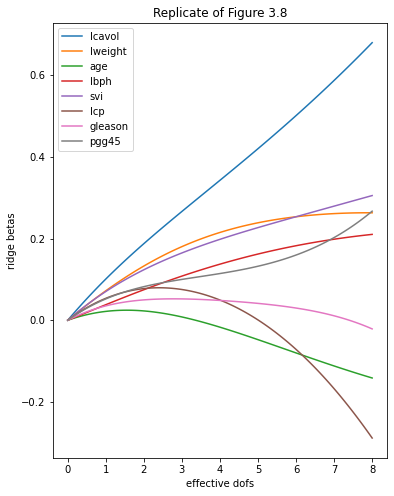

In [175]:
from sklearn.linear_model import Ridge
edofs = np.linspace(1e-5, 8, 100,endpoint=True)
alphas = [ newton(f(i), 0.) for i in edofs]
betas_ridge = np.vstack([ Ridge(alpha=a).fit(X_train, y_train).coef_   #this returns for each a beta_1(a) to beta_8(a)
                   for a in alphas])
print(betas_ridge.shape)
fig, ax =  plt.subplots(figsize = (6,8))
ax.plot(edofs,betas_ridge, label = columns)
ax.set_xlabel("effective dofs")
ax.set_ylabel("ridge betas")
ax.legend(loc = "upper left")
ax.set_title("Replicate of Figure 3.8")
print(np.allclose(betas_ridge[-1], lr.coef_))
plt.show()

- Use `GridSearchCV` and `KFold` from sklearn.model_selection to perform grid search cross-validation of different EDOFs, get mean squared error (MSE) to estimate expected prediction error (EPE) and its standard error. 
- Larger K means lower bias of the generalization error estimate, but higher variance since the training sets overlaps, but the validation/test sets do not overlap much in general. See [this](https://sebastianraschka.com/faq/docs/number-of-kfolds.html) post.

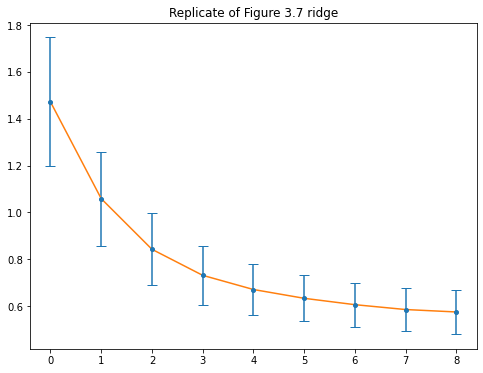

estimated EPEs =  [1.472 1.058 0.842 0.731 0.67  0.633 0.606 0.585 0.574]
se of estimated EPEs =  [0.275 0.2   0.154 0.125 0.108 0.099 0.094 0.093 0.094]


In [232]:
from sklearn.model_selection import GridSearchCV, KFold
np.set_printoptions(precision=3, suppress=False)

K, random_state = 10, 69438
cv = KFold(K, shuffle= True, random_state = random_state )
# Use the alphas (penalty multipliers) calculated above)
alphas = [ newton(f(i), 0.) for i in range(1,9)]
param_grid = {'alpha': alphas}


# break lines when parentheses left open, "\" no longer recommended
gs = (
    GridSearchCV(Ridge(), param_grid=param_grid,
                  cv = cv ,scoring='neg_mean_squared_error') 
                # if cv being set to be an integer is equiv to shuffle = False
); gs.fit(X_train, y_train); 
res = gs.cv_results_


from sklearn.dummy import DummyRegressor
# baseline is the regression on mean(y_train)
gs_baseline = (
    GridSearchCV(DummyRegressor(), param_grid={},
                  cv = cv ,scoring='neg_mean_squared_error')
); gs_baseline.fit(X_train, y_train); 
res_baseline = gs_baseline.cv_results_

# estimated expected prediction errors, and their standard deviations
est_EPE = - np.hstack( [ res_baseline['mean_test_score'], res['mean_test_score']])
est_EPE_se = np.hstack ( [ res_baseline['std_test_score'], res['std_test_score']])/np.sqrt(K-1)

# Plot the values against their indices with error bars
fig, ax = plt.subplots(figsize = (8,6))
ax.errorbar(np.arange(9), est_EPE, yerr=est_EPE_se, fmt='o', markersize=4, capsize=5)
ax.plot(np.arange(9), est_EPE)
ax.set_title("Replicate of Figure 3.7 ridge")
plt.show()
print("estimated EPEs = ", est_EPE)
print("se of estimated EPEs = ", est_EPE_se)

### Figures 3.7 (lasso) and 3.10 (ridge coeffs)

- Next we replicate the ridge regression `Lasso()` estimated EPE plot from Figure 3.7, and the profiles of the ridge coefficients Figure 3.10. 

- The minimization problem of the functional:
$$
\frac12 \sum_{i=1}^N \Big( y_i - \beta_0 - \sum_{j=1}^p x_{ij} \beta_j \Big) ^2 + \lambda\sum_{j=1}^p \big| \beta_j \big|
$$
one should first center and standardize $\mathbf X$.

- Penalty factor $\alpha$ `alpha` ( $\lambda$ in ESL ) is one by default in `Lasso`. Here as it becomes larger than approx. 0.94, all `coef_`s are shrunk to zero.

- `s` defined below is the standardizd parameter, given by
$$
s = \frac t { \sum_{j = 1}^p \big| \hat \beta_j \big|}
$$
where 
$$
t = \sum_{j = 1}^p \big| \hat \beta_j^\mathrm{lasso}(\alpha) \big|
$$

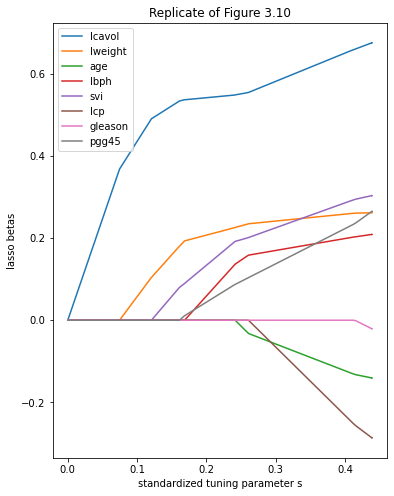

In [234]:
from sklearn.linear_model import Lasso
alpha = np.linspace(0., 0.94, 1001, endpoint=True) # set penalty multipliers
beta_ols = LinearRegression().fit(X_train, y_train).coef_ #betas of the alpha=0 case
betas_lasso = np.vstack((beta_ols,
    [ Lasso(alpha=a).fit(X_train, y_train).coef_   #this returns for each a beta_1(a) to beta_8(a)
                   for a in alpha[:-1]]
                        )) # concatenate beta_ols with the betas of lasso for alpha != 0
s = np.sum(np.abs(betas_lasso)/
           np.sum(np.abs(lr.coef_)),
           axis=1)
# standardized parameter 
# plot the lasso coefficient curves against the standardized parameter
fig, ax =  plt.subplots(figsize = (6,8));ax.plot(s , betas_lasso, label = columns)
ax.set_xlabel("standardized tuning parameter s");ax.set_ylabel("lasso betas");ax.legend(loc = "upper left");ax.set_title("Replicate of Figure 3.10")
plt.show()

- *Reducing number of active predictors ~ reducing the number of dof ~ reducing the risk hence the expected prediction error.*

- Randomized PCA see [this](https://gregorygundersen.com/blog/2019/01/17/randomized-svd/) page.
Restrict to the first $M\leq p$ principal components, and use them to perform OLS.

- For standardized $\mathbf X$ but not $\mathbf y$, 
$$
\hat{\mathbf y}^\mathrm{pcr}_{(M)} = \bar y \mathbf E_N + \sum_{m=1}^M \hat \theta_m \mathbf z_m = \bar y \mathbf E_N + \mathbf X \sum_{m=1}^M \hat \theta_m  v_m
$$
where $\mathbf z_m = \mathbf X v_m$ are the scores.

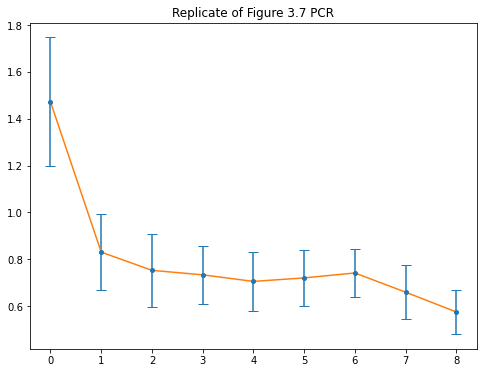

estimated EPEs =  [1.472 0.83  0.752 0.733 0.705 0.72  0.741 0.659 0.574]
se of estimated EPEs =  [0.275 0.161 0.157 0.125 0.128 0.12  0.101 0.115 0.094]


In [236]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyRegressor

pipeline = make_pipeline(PCA(), LinearRegression())
# sum( a[i] * lr.coef_[i] for i in range(7))

y_train.mean()

K = 10
param_grid  = {'pca__n_components': [1, 2, 3, 4, 5, 6, 7,8]} #this makes the GridSearch refers to the 'pca' in the pipeline transformer
cv = KFold(K, shuffle = True, random_state = random_state)
gs = (
    GridSearchCV(pipeline, param_grid=param_grid,
                  cv = cv ,scoring='neg_mean_squared_error') 
                # if cv being set to be an integer is equiv to shuffle = False
); gs.fit(X_train, y_train)
res = gs.cv_results_

# baseline is the regression on mean(y_train)
gs_baseline = (
    GridSearchCV(DummyRegressor(), param_grid={},
                  cv = cv ,scoring='neg_mean_squared_error')
); gs_baseline.fit(X_train, y_train); 
res_baseline = gs_baseline.cv_results_

# estimated expected prediction errors, and their standard deviations
est_EPE = - np.hstack( [ res_baseline['mean_test_score'], res['mean_test_score']])
est_EPE_se = np.hstack ( [ res_baseline['std_test_score'], res['std_test_score']])/np.sqrt(K-1)

# Plot the values against their indices with error bars
fig, ax = plt.subplots(figsize = (8,6))
ax.errorbar(np.arange(9), est_EPE, yerr=est_EPE_se, fmt='o', markersize=4, capsize=5)
ax.plot(np.arange(9), est_EPE)
ax.set_title("Replicate of Figure 3.7 PCR")
plt.show()
print("estimated EPEs = ", est_EPE)
print("se of estimated EPEs = ", est_EPE_se)

[ 0.  0.  0. -0.  0. -0. -0.]


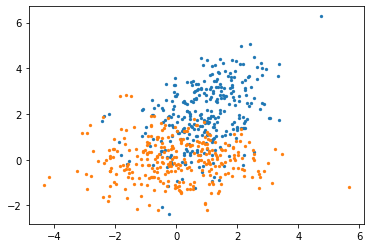

In [159]:
mean = np.array([1, 2])
cov = np.array([[1, 0.5], [0.5, 2]])

# Generate random samples
X1 = np.random.multivariate_normal(mean, cov, 300)
X1_transformed = PCA(n_components =2).fit_transform(X1)
plt.scatter(X1[:,0],X1[:,1],marker='.',linewidth=0.3)
plt.scatter(X1_transformed[:,0],X1_transformed[:,1], marker='.', linewidth = .3)
print(np.mean(X_train, axis = 0))

In [997]:
np.array([np.random.normal(loc=0, scale=j,size=1) for j in 0.1*np.arange(20)]);

CV estimates the EPE, the EXPECTED predicted error over the space of training sets $\mathcal T$.

In [1078]:
X, y = np.arange(15), np.arange(15)
kf = KFold(n_splits=4, shuffle=False, random_state = None)
kf.get_n_splits(X)
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[ 4  5  6  7  8  9 10 11 12 13 14]
  Test:  index=[0 1 2 3]
Fold 1:
  Train: index=[ 0  1  2  3  8  9 10 11 12 13 14]
  Test:  index=[4 5 6 7]
Fold 2:
  Train: index=[ 0  1  2  3  4  5  6  7 12 13 14]
  Test:  index=[ 8  9 10 11]
Fold 3:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11]
  Test:  index=[12 13 14]


In [231]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cross_decomposition import PLSRegression
from sklearn.dummy import DummyRegressor